# __Table of Contents__

<ol>
    <li><a href="#Objectives">Objectives</a></li>
    <li>
        <a href="#Setup">Setup</a>
        <ol>
            <li><a href="#Installing-Required-Libraries">Installing Required Libraries</a></li>
        </ol>
    </li>
    <li>
        <a href="#Parkinson Data and Voice Disorder">Parkinson Data and Voice Disorder</a>
    </li>
    <li><a href="#Loading Data">Loading Data</a></li>
    <li><a href="#Data Preparation">Data Preparation</a></li>
    <li><a href="#Train and Test Random Forest">Train and Test Random Forest Model</a></li>
    <li><a href="#Visualizing the decision tree">Find Strong Model</a></li>
</ol>


# Objectives

The goal of this project is to create a machine learning model capable of accurately predicting the presence of Parkinson's disease in individuals based on their voice recordings. Parkinson's disease is a neurodegenerative condition that impairs movement, resulting in symptoms such as tremors, rigidity, and difficulties with coordination.



----


# Setup


# Installing Required Libraries


In [ ]:
#%%capture
#!mamba install -- upgrade scikit-learn=1.2.1
#!mamba install seaborn --y

In [1]:
!pip install dtreeviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 966.3 kB/s eta 0:00:00


# Importing Required Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')


## Creating helper function for plotting


In [3]:
sns.set(style="whitegrid", color_codes=True)
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = 3*cm.max()/4
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Loading data


In [6]:
data = pd.read_csv("parkinsons.csv", sep=',', index_col='name') # assign index column to name
data.head()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
name,,,,,,,,,,,,,,,,,,,,,
phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


## we can see the number of samples


In [7]:
print(data.shape)

(195, 23)


## To improve our understanding of the variables involved in parkinson detection, we first need to analyze the relationships within the data. Correlation diagrams can be helpful in visualizing how different variables are associated with each other and with parkinson status. Additionally, random forest models can help identify the importance of different features in predicting the target variable (parkinson).


<Axes: >

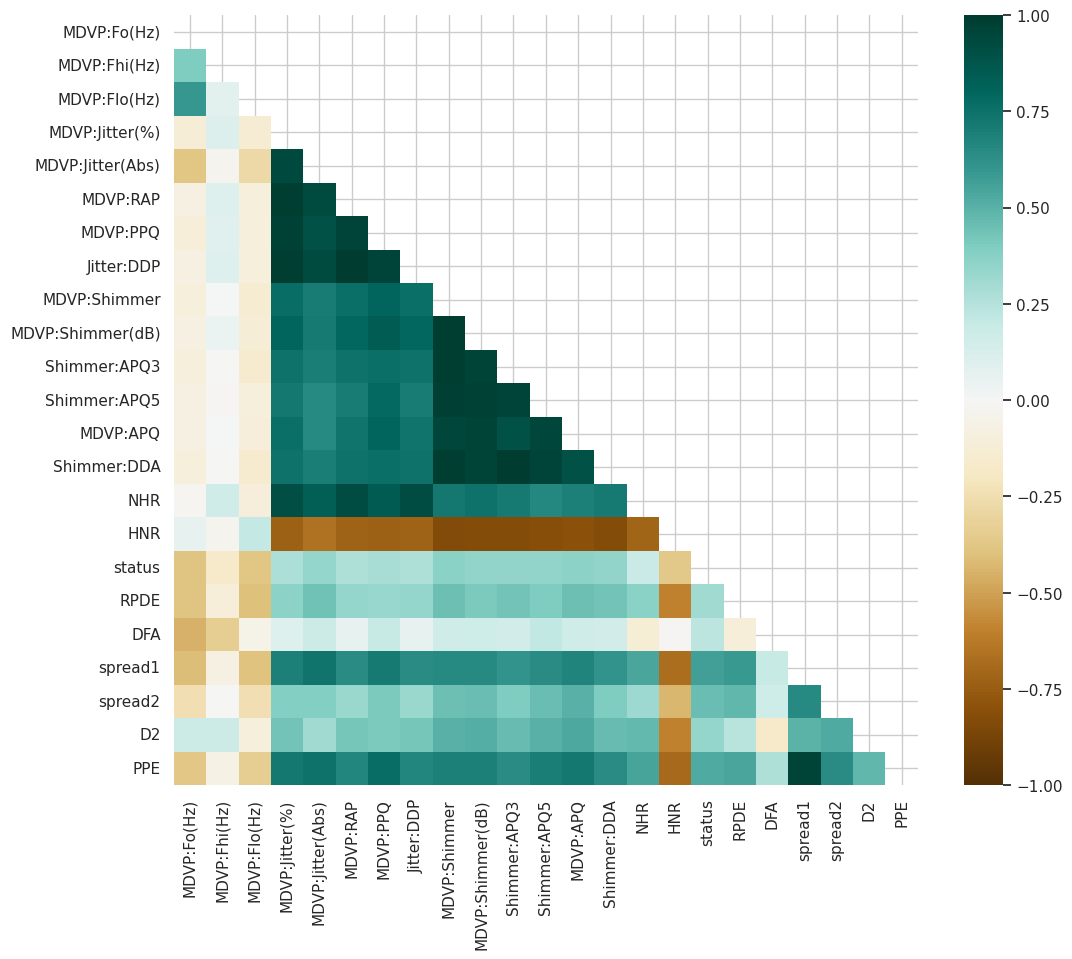

In [9]:
# creating the correlation matrix
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(data.corr(), dtype=np.bool_))
sns.heatmap(data.corr(),vmin=-1, vmax=1,cmap='BrBG', mask=mask)

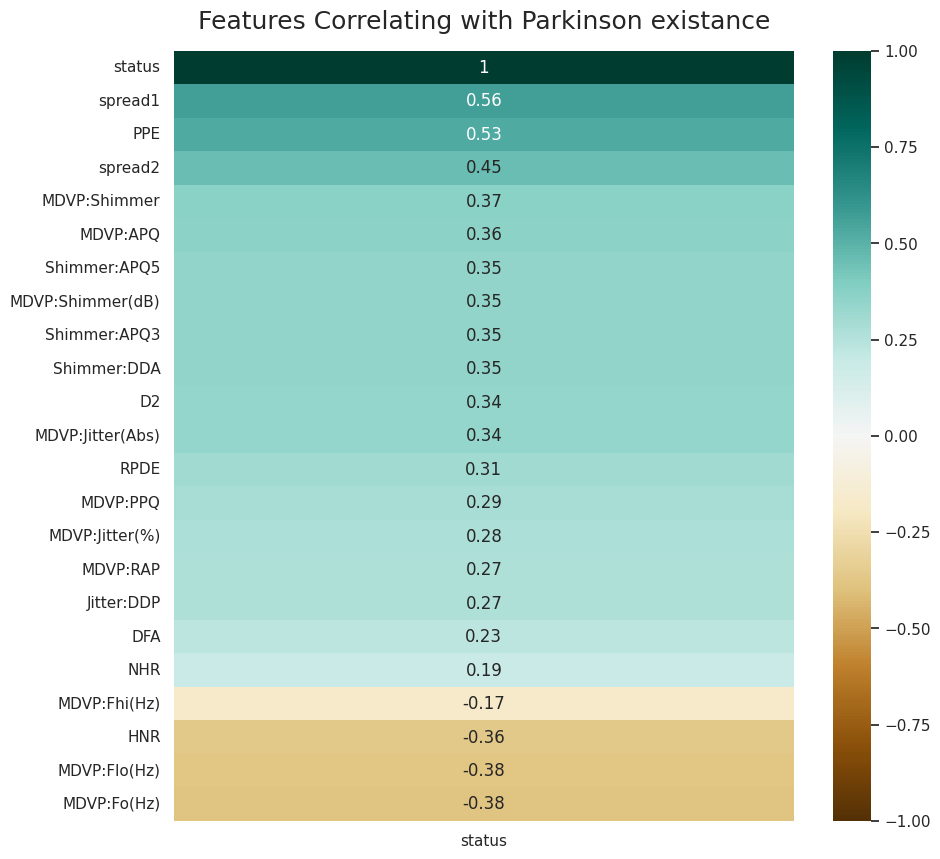

In [10]:
# modify the headmap plot to show correlation variables to the status
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(data.corr()[['status']].sort_values(by='status', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Parkinson existance', fontdict={'fontsize':18}, pad=16);

## Let's get the  features we select all columns in the dataset except for the `status` column. This is done using the ```drop``` method, which returns a new DataFrame with the specified columns (in this case, 'status') removed. The `axis=1` argument indicates that we're dropping a column, not a row.


In [11]:
X = data.drop('status', axis=1)
X.head()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE
name,,,,,,,,,,,,,,,,,,,,,
phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,...,0.02971,0.06545,0.02211,21.033,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,...,0.04368,0.09403,0.01929,19.085,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,...,0.03590,0.08270,0.01309,20.651,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,...,0.03772,0.08771,0.01353,20.644,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,...,0.04465,0.10470,0.01767,19.649,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


## The   Health status of the subject (one) - Parkinson's, (zero) - healthy  is given in the ```status``` column:


In [12]:
y=data['status']
y.head()

name
phon_R01_S01_1    1
phon_R01_S01_2    1
phon_R01_S01_3    1
phon_R01_S01_4    1
phon_R01_S01_5    1
Name: status, dtype: int64

### we can see that 3/4 of the samples are have Parkinson's


In [13]:
y.value_counts(normalize=True)

status
1    0.753846
0    0.246154
Name: proportion, dtype: float64

## t-SNE (t-Distributed Stochastic Neighbor Embedding) is a machine learning technique used for dimensionality reduction and visualization of high-dimensional datasets. It is particularly useful for visualizing complex data structures, as it helps to project the data points from a high-dimensional space to a lower-dimensional space (usually 2D or 3D) while preserving the relationships between the data points as much as possible. Lets apply it to our dataset:


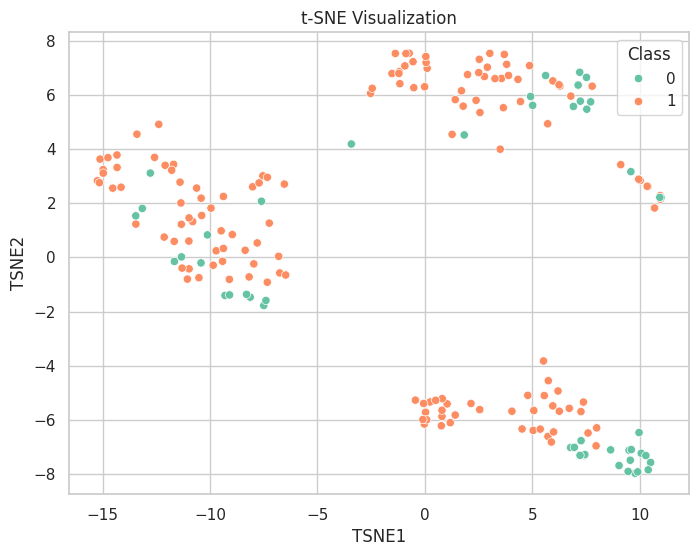

In [14]:
import seaborn as sns
from sklearn.manifold import TSNE

# Apply t-SNE to reduce the dimensions to 2
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

# Create a DataFrame with the t-SNE-transformed data and class labels
tsne_df = pd.DataFrame(data=X_tsne, columns=['TSNE1', 'TSNE2'])
tsne_df['Class'] = y.values

# Visualize the data based on class using a scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=tsne_df, x='TSNE1', y='TSNE2', hue='Class', palette='Set2')
plt.title('t-SNE Visualization')
plt.show()

# Data preparation

## Here, we are splitting a dataset into independent and dependent variables, and then splitting it further into training and testing sets.


In [15]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=11)


# print the shape of train and test data
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (136, 22)
y_train shape:  (136,)
X_test shape:  (59, 22)
y_test shape:  (59,)


# k-Nearest Neighbors (k-NN)


## K-NN


## In k-NN, the basic idea is to predict the label of a new instance based on the labels of its k nearest neighbors in the training data.

## We import the library


In [16]:
from sklearn.neighbors import KNeighborsClassifier

## we create a knn object


In [17]:
knn = KNeighborsClassifier(n_neighbors=3)

## we fit the object


In [18]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

## Make predictions on the testing data


In [19]:
y_pred = knn.predict(X_test)
y_pred[0:10]

array([1, 0, 1, 1, 1, 1, 1, 0, 0, 0])

## We can  get a probability of belonging to a each class for each sample, here are the first ten


In [20]:
knn.predict_proba(X_test)[0:10]

array([[0.33333333, 0.66666667],
       [0.66666667, 0.33333333],
       [0.33333333, 0.66666667],
       [0.33333333, 0.66666667],
       [0.        , 1.        ],
       [0.33333333, 0.66666667],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ]])

## The confusion matrix is a table that shows the number of true positive, true negative, false positive, and false negative predictions. The classification report provides the precision, recall, F1-score, and support for each class, which are important metrics for evaluating the performance of a classifier. The accuracy score is a simple metric that calculates the proportion of correct predictions out of the total predictions made by the model. These three elements together provide a comprehensive evaluation of the classifier's performance on the test dataset. Let's prints the confusion matrix, classification report, and accuracy score for a given classification model.


In [21]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

Confusion matrix, without normalization
[[ 9  3]
 [ 5 42]]


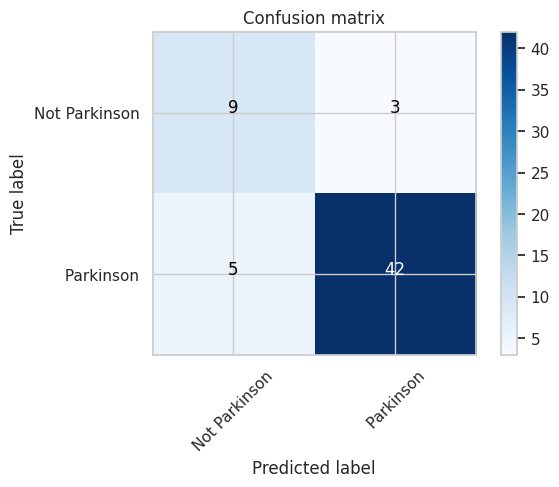

In [22]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred),classes=[ "Not Parkinson", " Parkinson"],title='Confusion matrix')

In [23]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.75      0.69        12
           1       0.93      0.89      0.91        47

    accuracy                           0.86        59
   macro avg       0.79      0.82      0.80        59
weighted avg       0.87      0.86      0.87        59


Accuracy Score: 0.864406779661017


# GridSearchCV


### In the code above, we randomly selected the hyperparameter ```K``` for our KNN classifier. However, in order to find the optimal hyperparameters that maximize the performance metric, we will perform a grid search. To do this, we define a parameter grid that we will search over for ```K```.


In [24]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9],

}

## Define the KNN classifier object


In [25]:

knn = KNeighborsClassifier()



### In medical testing, recall is a measure of the ability of a test to correctly identify true positive cases, or the proportion of actual positive cases that are correctly identified by the test. A high recall means that the test is able to correctly identify a large proportion of true positive cases, even if it may also produce some false positive results, therefore for ```scoring``` we select recall . The choice of performance metric for a machine learning model may depend on several factors.

### The next cell  performs a grid search over the hyperparameters of a KNN classifier using ```GridSearchCV()``` function from scikit-learn library. The param_grid parameter specifies a dictionary of hyperparameters to search over, while the scoring parameter specifies the performance metric to optimize for, which in this case is the recall. The cv parameter specifies the number of folds for cross-validationv ```cv``` . The resulting grid_search object can be used to fit the data and obtain the best hyperparameters that maximize the performance metric.


In [26]:
from sklearn.model_selection import GridSearchCV


grid_search = GridSearchCV(knn, param_grid, scoring='recall', cv=5)

grid_search

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7, 9]}, scoring='recall')

## Fit the grid search to the training data


In [27]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7, 9]}, scoring='recall')

## Print the best parameters and score on validation data


In [28]:
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Parameters:  {'n_neighbors': 9}
Best Score:  0.97


### Get the predicted labels on the test data using the best estimator:


In [29]:
y_pred = grid_search.best_estimator_.predict(X_test)

## Calculate the recall score on the test data using the predicted labels:


In [30]:
from sklearn.metrics import recall_score
recall = recall_score(y_test, y_pred)

recall

0.9148936170212766

### we can make a prediction


In [31]:
y_hat = grid_search.best_estimator_.predict(X)

### Now we use all our data to train the model


In [32]:
knn = KNeighborsClassifier()
knn.fit(X,y)

KNeighborsClassifier()

### let's study our predictions  


In [33]:
y_hat =knn.predict(X)

### we can plot the confusion matrix


Confusion matrix, without normalization
[[ 32  16]
 [  5 142]]


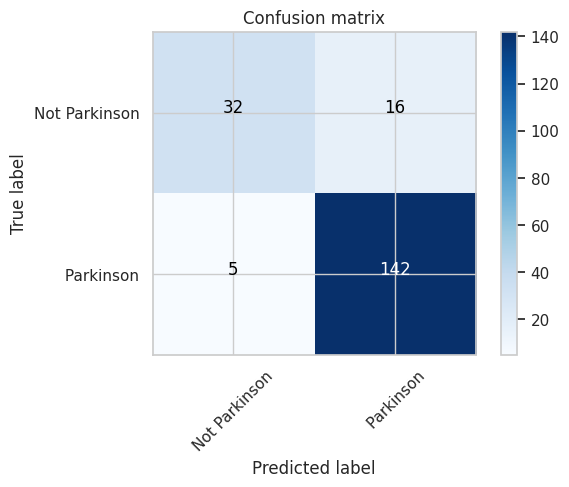

In [34]:
plot_confusion_matrix(confusion_matrix(y, y_hat),classes=[ "Not Parkinson", " Parkinson"],title='Confusion matrix')

### let's label true positives, false positives, true negatives, and false negatives


# Machine Learning Interpretability
## Machine learning interpretability refers to the ability to understand and explain how a machine learning model arrives at its predictions or decisions. It is an important aspect of machine learning because it enables users to gain insight into how a model works, assess its strengths and limitations, and identify potential issues such as bias, errors, or overfitting. Interpretability can be achieved through a variety of techniques such as visualizations, feature importance scores, model-agnostic methods, and explanations of specific decisions.
## T-SNE can be used for machine learning interpretability by visualizing high-dimensional data in a two-dimensional space.  For example, in the context of clustering, t-SNE can be used to visualize the clusters in a two-dimensional space, making it easier to identify patterns and relationships between the data points. This can help to identify outliers, clusters that are not well-separated, and potentially interesting subsets of the data that may warrant further investigation. Let's label our predictions


In [35]:
# find true positives(tp)
tsne_df['label']=''
tsne_df['label'].iloc[np.where((y_hat == 1) & (y == 1))]="TP"
# find true negatives (tn)
tsne_df['label'].iloc[np.where((y_hat == 0) & (y == 0))]="TN"
# find false positives (fp)
tsne_df['label'].iloc[np.where((y_hat == 1) & (y == 0))]="FP"
# find false negatives (fp)
tsne_df['label'].iloc[np.where((y_hat == 0) & (y == 1))]="FN"

## Let's plot the data, with the labeled predictions


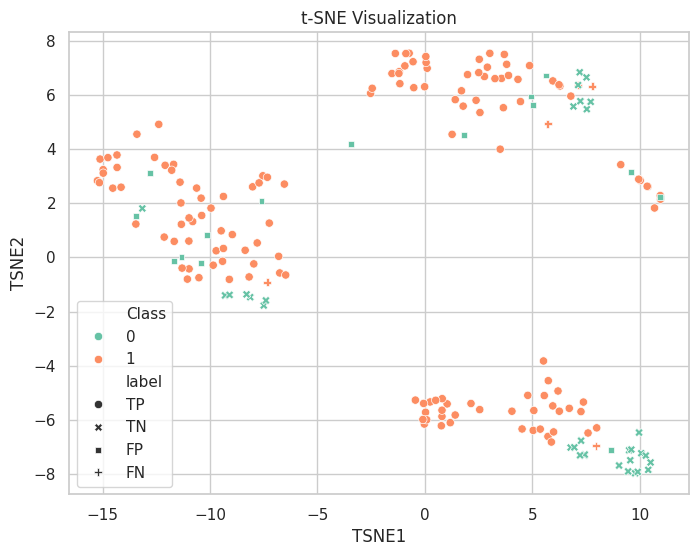

In [36]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=tsne_df, x='TSNE1', y='TSNE2', hue='Class', palette='Set2',style='label')
plt.title('t-SNE Visualization')
plt.show()

## From the plot, we see most of the errors are confined to specific clusters. We can apply clustering to our data before we classify the data, but let's try several other models. Here are several more libraries for Machine Learning Interpretability


<ul>
  <li><a href="https://github.com/slundberg/shap">SHAP</a></li>
  <li><a href="https://github.com/marcotcr/lime">LIME</a></li>
  <li><a href="https://github.com/oracle/Skater">Skater</a></li>
  <li><a href="https://github.com/microsoft/interpret">Microsoft InterpretML</a></li>
  <li><a href="https://github.com/interpretml/interpret-text">Interpret-text</a></li>
  <li><a href="https://github.com/interpretml/interpret-core">Interpret-core</a></li>
  <li><a href="https://github.com/surrey-unplugged/saliency">Saliency</a></li>
  <li><a href="https://github.com/PAIR-code/facets">Facets</a></li>
  <li><a href="https://github.com/marcotcr/photonai">Photonai</a></li>
</ul>


# Logistic Regression


## here's an example code for fitting a logistic regression model using scikit-learn, it's almost identical to K-NN , first we import ```LogisticRegression```


In [37]:
from sklearn.linear_model import LogisticRegression

 ## We create and fit logistic regression model ```lr``` and fit it


In [38]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

## we can make a prediction on the first ten samples


In [39]:
y_pred = lr.predict(X_test)
y_pred[0:10]

array([1, 0, 1, 1, 1, 1, 1, 0, 0, 0])

## We can get a probability of belonging to a each class for each sample, here are the first ten


In [40]:
lr.predict_proba(X_test)[0:10]


array([[0.26796849, 0.73203151],
       [0.69161219, 0.30838781],
       [0.06764952, 0.93235048],
       [0.38588988, 0.61411012],
       [0.07237225, 0.92762775],
       [0.26252443, 0.73747557],
       [0.00912184, 0.99087816],
       [0.5108703 , 0.4891297 ],
       [0.85915321, 0.14084679],
       [0.90263876, 0.09736124]])

## We can display the confusion matrix as well as a classification report


Confusion matrix, without normalization
[[ 9  3]
 [ 6 41]]

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.75      0.67        12
           1       0.93      0.87      0.90        47

    accuracy                           0.85        59
   macro avg       0.77      0.81      0.78        59
weighted avg       0.86      0.85      0.85        59


Accuracy Score: 0.847457627118644


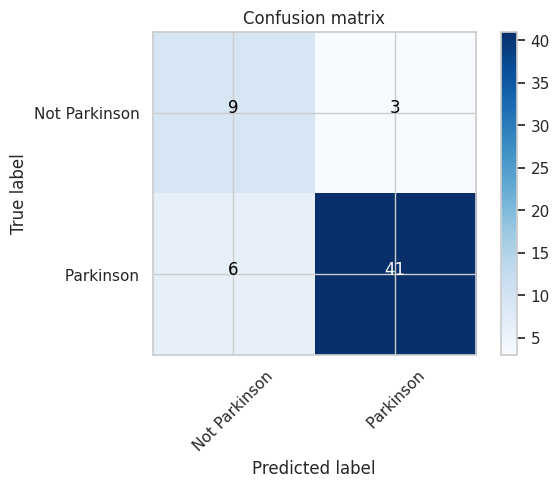

In [41]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred),classes=[ "Not Parkinson", " Parkinson"],title='Confusion matrix')
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))

## While grid search can be used to optimize hyperparameters for many machine learning algorithms, the hyperparameters in logistic regression may not be particularly insightful. Instead, we can use logistic regression to identify feature importance, as the coefficients learned during training can reveal which features are most strongly associated with the target variable. We can obtain the coefficients.


In [42]:
coef=abs(lr.coef_[0])

## the coefficients represent the impact of each feature on the probability of the positive class, So larger the magnitude  of the coefficients  are more important the feature


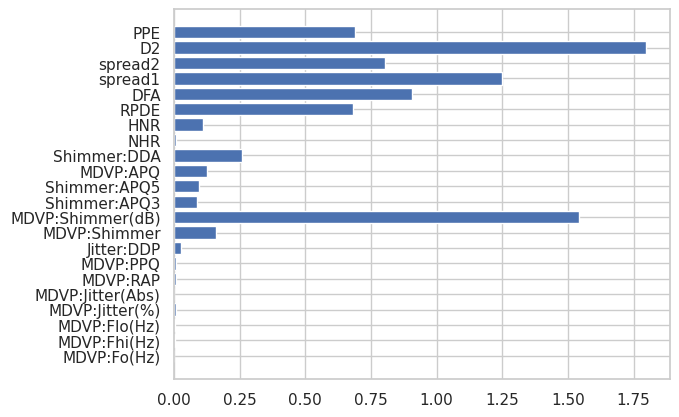

In [43]:
plt.barh(X.columns, coef)
plt.show()

## We can select the features with the highest magnitude coefficients


In [44]:
best_columns=X.columns[np.argsort(-1*coef)[0:5]]
best_columns

Index(['D2', 'MDVP:Shimmer(dB)', 'spread1', 'DFA', 'spread2'], dtype='object')

Confusion matrix, without normalization
[[ 9  3]
 [ 6 41]]

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.75      0.67        12
           1       0.93      0.87      0.90        47

    accuracy                           0.85        59
   macro avg       0.77      0.81      0.78        59
weighted avg       0.86      0.85      0.85        59


Accuracy Score: 0.847457627118644


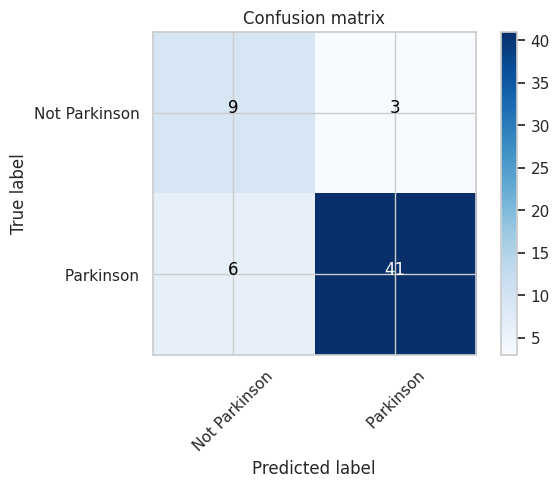

In [45]:
log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(X_train[best_columns], y_train)

# Get the predicted probabilities for each class
y_pred_proba = log_reg.predict_proba(X_test[best_columns])

plot_confusion_matrix(confusion_matrix(y_test, y_pred),classes=[ "Not Parkinson", " Parkinson"],title='Confusion matrix')
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))

### We see many of the  features are redundant, identifying and removing redundant features can potentially help in a few ways.

### First, it can reduce the amount of data required for the model, which can reduce the cost of storing and processing data.

### Second, it can improve the performance of the model, allowing it to make more accurate predictions with fewer resources. This can help reduce the cost of misclassifications or errors in the predictions.

### Finally, it can also reduce the cost of model development and maintenance. Removing redundant features can simplify the model, making it easier to develop and maintain over time. It can also reduce the need for frequent updates and retraining, which can be costly in terms of time and resources


# Support Vector Machines (SVM)


### SVM stands for Support Vector Machines. It is a type of supervised machine learning algorithm used for classification. The algorithm identifies a hyperplane (or a set of hyperplanes) in an n-dimensional space that maximally separates the different classes in the dataset. The hyperplane that is selected is the one that has the maximum margin between the closest points of different classes, known as support vectors. SVM is particularly effective in high-dimensional datasets where other algorithms may have difficulty in identifying a clear boundary between the classes. SVM is also versatile in the type of kernel functions that can be used to transform the data into higher dimensions, such as linear, polynomial, and radial basis function (RBF) kernels.

## Like Logistic Regression SVM is a linear classifier but there are some Pros and Cons

## Pros of SVM over Logistic Regression
<ul>
<li>Effective in high dimensional spaces and with datasets that have a lot of features</li>
<li>Can handle non-linearly separable data using kernel trick</li>
<li>Robust to overfitting due to the regularization parameter</li>
</ul>

## Cons of SVM compared to Logistic Regression<b>
<ul>
<li>Can be computationally expensive to train, especially with large datasets</li>
<li>Difficult to interpret the results and understand the impact of each feature on the model</li>
<li>Requires careful selection of hyperparameters to achieve optimal performance</li>
</ul>

You can train a SVM just like any other model


# Train and Test SVM Model using the SVC constructor and display the confusion matrix

Confusion matrix, without normalization
[[ 4  8]
 [ 2 45]]


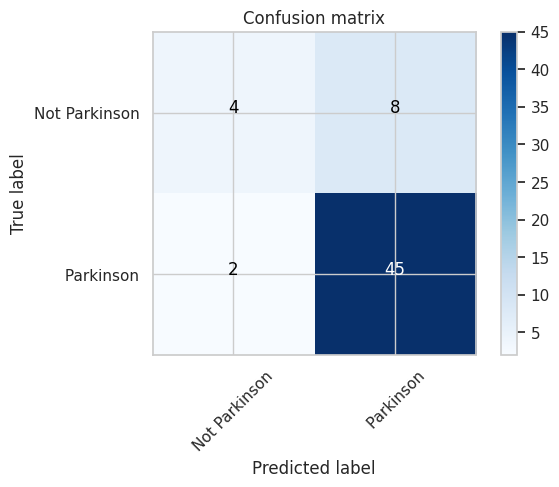

In [46]:
from sklearn.svm import SVC
# Train the SVM classifier
svm = SVC()
svm.fit(X_train, y_train)

# Make predictions on the test set
y_hat = svm.predict(X_test)

# confusion_matri
plot_confusion_matrix(confusion_matrix(y_test, y_hat),classes=[ "Not Parkinson", " Parkinson"],title='Confusion matrix')

## Here are the explanations for some of the important parameters:
    
## ```C:``` Regularization parameter. A smaller value of C creates a wider margin but may lead to more misclassifications, while a larger value of C creates a narrower margin but may lead to overfitting

## ```kernel:``` Type of kernel function used to transform the data into a higher-dimensional space where it can be linearly separated. Common choices include linear, polynomial, and radial basis function (RBF) kernels

## ```gamma:``` Kernel coefficient for RBF, polynomial, and sigmoid kernels. A smaller value of gamma creates a larger influence radius for the support vectors, while a larger value of gamma creates a smaller influence radius and can lead to overfitting

## ```degree:``` Degree of the polynomial kernel function. Only used for polynomial kernel.    
    


## here is a dictionary for grid search with some of the specified parameters:


In [47]:
param_grid = {
    'C': [0.1, 1,],
    'gamma': [0.1, 1, 10],

}

# Performing grid search on an SVM classifier with the specified hyperparameters and using recall as the scoring metric to find the best hyperparameters and the corresponding recall score:


In [48]:
from sklearn.svm import SVC
# Train the SVM classifier
svm = SVC()
# Create a GridSearchCV object
grid_search = GridSearchCV(svm, param_grid, scoring='recall', cv=2)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding recall score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best recall score: ", grid_search.best_score_)


Best hyperparameters:  {'C': 0.1, 'gamma': 0.1}
Best recall score:  1.0


#  Random Forest Model



## Random Forest is a good choice for various machine learning tasks due to its high accuracy in classifying complex data patterns. The ability to interpret the results of Random Forest models also makes it easier to validate and understand the decisions it makes.


In [49]:
from sklearn.ensemble import RandomForestClassifier
# Create a Random Forest model
rf = RandomForestClassifier(random_state=123)

# Train the model on the training data
rf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 89.83%


# Perform grid search for RandomForest to tune the parameters


In [50]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search over
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'max_features': ['sqrt', 'log2']
}

# Create a random forest classifier
rf = RandomForestClassifier(random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)
rf.fit(X_train, y_train)

# Print the best hyperparameters
print("Best parameters:", grid_search.best_params_)

# Get the best model
best_model = grid_search.best_estimator_

Best parameters: {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 100}


<Axes: >

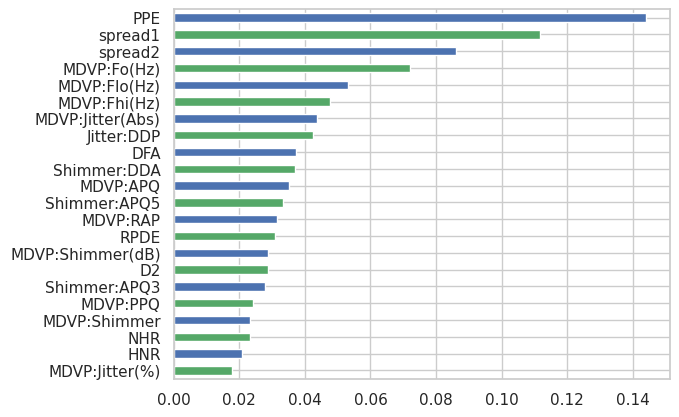

In [51]:
# plot the important features
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances.sort_values().plot(kind='barh',color=['g','b'])

In [52]:
input_data = (197.07600,206.89600,192.05500,0.00289,0.00001,0.00166,0.00168,0.00498,0.01098,0.09700,0.00563,0.00680,0.00802,0.01689,0.00339,26.77500,0.422229,0.741367,-7.348300,0.177551,1.743867,0.085569)

# changing input data to a numpy array
input_data_as_numpy_array = np.asarray(input_data)

# reshape the numpy array
input_data_reshaped = input_data_as_numpy_array.reshape(1,-1)

prediction = rf.predict(input_data_reshaped)
print(prediction)


if (prediction[0] == 0):
  print("The Person does not have Parkinsons Disease")

else:
  print("The Person has Parkinsons")

[0]
The Person does not have Parkinsons Disease


### To save the trained model we utilize liberary `pickle`


In [53]:
import pickle


In [54]:
filename = 'parkinsons_model.sav'
pickle.dump(rf, open(filename, 'wb'))

In [55]:
# loading the saved model
loaded_model = pickle.load(open('parkinsons_model.sav', 'rb'))

In [56]:
for column in X.columns:
  print(column)

MDVP:Fo(Hz)
MDVP:Fhi(Hz)
MDVP:Flo(Hz)
MDVP:Jitter(%)
MDVP:Jitter(Abs)
MDVP:RAP
MDVP:PPQ
Jitter:DDP
MDVP:Shimmer
MDVP:Shimmer(dB)
Shimmer:APQ3
Shimmer:APQ5
MDVP:APQ
Shimmer:DDA
NHR
HNR
RPDE
DFA
spread1
spread2
D2
PPE
